In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from flask import Flask, jsonify
from pprint import pprint

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")
conn = engine.connect()
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
df_for_measurement = pd.read_sql("select * from Measurement", conn)
df_for_measurement.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [11]:
df_for_station = pd.read_sql("select * from Station", conn)
df_for_station.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


# Exploratory Climate Analysis

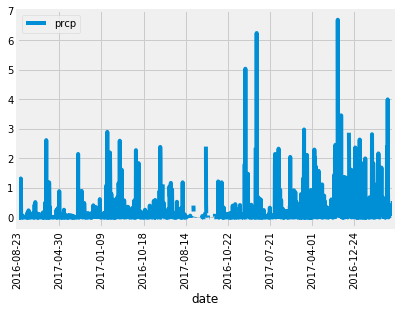

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores
df_for_measurement_subset = pd.read_sql("select date, prcp from Measurement where date between '2016-08-23' and '2017-08-23'", conn)
# Save the query results as a Pandas DataFrame and set the index to the date column
df_for_measurement_subset = df_for_measurement_subset.set_index("date")
df_for_measurement_subset.head()
# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data
df_for_measurement_subset.plot(rot=90)
plt.show()

![precipitation](Images/precipitation.png)

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_for_measurement_subset.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [14]:
# Design a query to show how many stations are available in this dataset?
df_for_station["station"].count()

9

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
df_for_measurement["station"].value_counts()

USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838     511
Name: station, dtype: int64

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
df_for_measurement["tobs"].loc[df_for_measurement["station"]=="USC00519281"].min()

54.0

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

df_for_measurement["tobs"].loc[df_for_measurement["station"]=="USC00519281"].max()

85.0

In [18]:

df_for_measurement["tobs"].loc[df_for_measurement["station"]=="USC00519281"].mean()

71.66378066378067

![precipitation](Images/station-histogram.png)

In [19]:
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
import datetime
from dateutil.parser import parse

def prev_yr_temps(start_date, end_date):
    new_start_date = datetime.datetime.strptime(start_date, '%Y-%m-%d')
    prev_yr_start2 = new_start_date - datetime.timedelta(days=365)
    
    new_end_date = datetime.datetime.strptime(end_date, '%Y-%m-%d')
    prev_yr_end2 = new_end_date - datetime.timedelta(days=365)
    
    return calc_temps(prev_yr_start2, prev_yr_end2)

print(prev_yr_temps('2012-02-28', '2012-03-05'))

prev_yr_temps = prev_yr_temps('2012-02-28', '2012-03-05')

[(61.0, 70.17021276595744, 75.0)]


In [21]:
june_df = pd.read_sql("select * from Measurement where (date between '2010-06-01' and '2010-06-30') or (date between '2011-06-01' and '2011-06-30') or (date between '2012-06-01' and '2012-06-30') or (date between '2013-06-01' and '2013-06-30') or (date between '2014-06-01' and '2014-06-30') or (date between '2015-06-01' and '2015-06-30') or (date between '2016-06-01' and '2016-06-30') or (date between '2017-06-01' and '2017-06-30')", conn)
june_df.head()
june_temps = list(june_df['tobs'])
june_df["tobs"].mean()

74.94411764705882

In [22]:
dec_df = pd.read_sql("select * from Measurement where (date between '2010-12-01' and '2010-12-31') or (date between '2011-12-01' and '2011-12-31') or (date between '2012-12-01' and '2012-12-31') or (date between '2013-12-01' and '2013-12-31') or (date between '2014-12-01' and '2014-12-31') or (date between '2015-12-01' and '2015-12-31') or (date between '2016-12-01' and '2016-12-31') or (date between '2017-12-01' and '2017-12-31')", conn)
dec_df.head()
dec_temps = list(dec_df['tobs'])
dec_df["tobs"].mean()

71.04152933421226

In [23]:
import scipy.stats

ttest = list(scipy.stats.ttest_ind(dec_temps,june_temps))
print(ttest)

[-31.60372399000329, 3.9025129038616655e-191]


In [24]:
pvalue = ttest[1]

if pvalue < 0.5:
    print("This is statistically signifcant.")
else:
    print("This is not statistically significant.")

This is statistically signifcant.


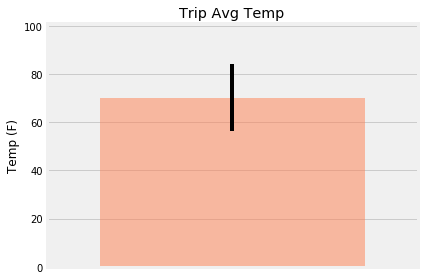

In [25]:
plt.bar(1,height=prev_yr_temps[0][1], yerr=(prev_yr_temps[0][2]-prev_yr_temps[0][0]), color="coral",alpha=.5)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.xticks(ticks=range(1))
plt.margins(.2,.2)
plt.tight_layout()
plt.show()